train_32x32.mat downloaded.
test_32x32.mat downloaded.
Train images shape: (32, 32, 3, 73257)
Train labels shape: (73257, 1)
Test images shape: (32, 32, 3, 26032)
Test labels shape: (26032, 1)
Reshaped train images: (73257, 32, 32, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 90s 95ms/step - accuracy: 0.3688 - loss: 1.7989 - val_accuracy: 0.8277 - val_loss: 0.5971
Epoch 2/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 88s 96ms/step - accuracy: 0.8027 - loss: 0.6669 - val_accuracy: 0.8698 - val_loss: 0.4494
Epoch 3/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 86s 94ms/step - accuracy: 0.8424 - loss: 0.5359 - val_accuracy: 0.8768 - val_loss: 0.4122
Epoch 4/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 145s 97ms/step - accuracy: 0.8612 - loss: 0.4734 - val_accuracy: 0.8901 - val_loss: 0.3821
Epoch 5/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 87s 95ms/step - accuracy: 0.8749 - loss: 0.4278 - val_accuracy: 0.8969 - val_loss: 0.3541
Epoch 6/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 88s 96ms/step - accuracy: 0.8859 - loss: 0.3840 - val_accuracy: 0.8992 - val_loss: 0.3470
Epoch 7/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 141s 95ms/step - accuracy: 0.8938 - loss: 0.3584 - val_accuracy: 0.8950 - val_loss: 0.3548
Epoch 8/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 142s 94ms/step - accuracy: 0.8992 - loss: 0.3411

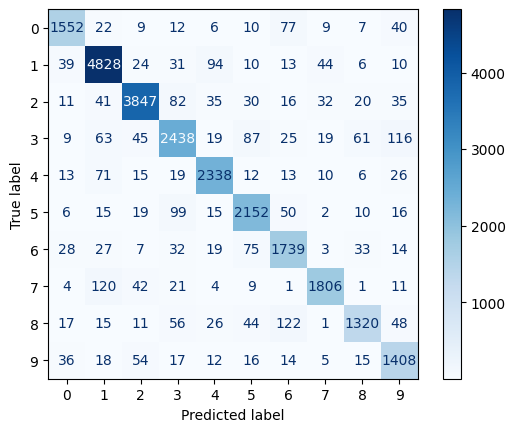

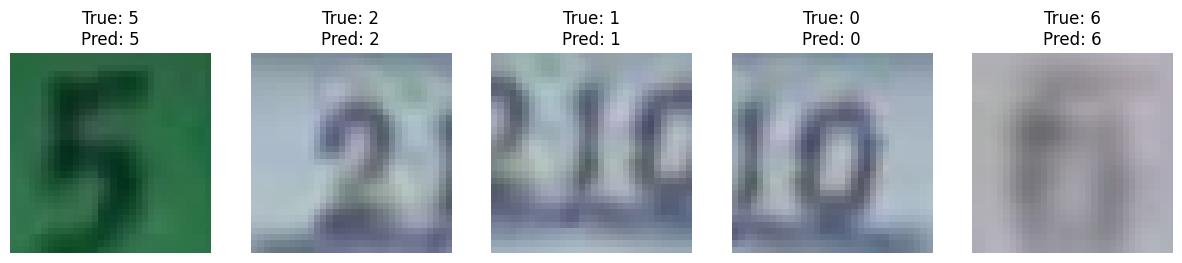

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import requests

# Helper function to download the dataset if not already present
def download_svhn(filename, url):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        response = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"{filename} downloaded.")

# Download the SVHN dataset if not available
train_url = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
test_url = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"

train_file = "train_32x32.mat"
test_file = "test_32x32.mat"

download_svhn(train_file, train_url)
download_svhn(test_file, test_url)

# 1. Load the SVHN dataset
svhn_train = loadmat(train_file)
svhn_test = loadmat(test_file)

# Extract images and labels
X_train = svhn_train['X']
y_train = svhn_train['y']
X_test = svhn_test['X']
y_test = svhn_test['y']

# 2. Check the data shape
print("Train images shape:", X_train.shape)  # (32, 32, 3, num_samples)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

# Reshape the data to match TensorFlow's expected input
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)
print("Reshaped train images:", X_train.shape)  # Now (num_samples, 32, 32, 3)

# 3. Normalize the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Correct labels: In the dataset, the label '10' represents '0', fix it
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 4. Split the train set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 5. Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 6. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

# 7. Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# 8. Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 9. Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# 10. Visualize test samples with predicted and true labels
# Choose indices for samples to display
indices = [0, 1, 2, 3, 4]  # You can choose any indices of interest

# Plot the selected test samples
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(1, len(indices), i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {y_true[idx]}\nPred: {y_pred_classes[idx]}")
    plt.axis('off')

plt.show()